# Attention Monitoring

Performed image and video classification with a Convolutional Neural Network in Python using PyTorch.
- Fine-tuned the top layers of a [ResNeXt-101-32x8d](https://pytorch.org/hub/pytorch_vision_resnext/) model pre-trained with the [ImageNet](https://image-net.org/) dataset.
- Used model to classify video clips and live video feed.

CHANGE
<img align="left" src="../notebook_pics/structure.png">

<p><a name="sections"></a></p>

## Sections
- <a href="#Data">Data</a><br>
- <a href="#Data Pre-processing">Data Pre-processing</a><br>
- <a href="#Transfer Learning">Transfer Learning: Fine Tuning</a><br>
    - <a href="#Load and Modify">Load and Modify</a><br>
    - <a href="#Training">Training</a><br>
    - <a href="#Re-training">Re-training</a><br>
- <a href="#Glimpse">A Glimpse into the CNN</a><br>
- <a href="#Video Classification">Video Classification</a><br>
- <a href="#Results">Results</a><br>

<p><a name="Data"></a></p>

## Data
I compiled, prepared, labeled and split the images myself. 
- 10427 images in total.
    - Attentive: 5318 
    - Not Attentive: 5109 
- Roughly a 70-15-15 split among the training, validating, and testing sets.
    - Train: 7302
    - Validate: 1561
    - Test: 1564
    

In [1]:
# Construct the path
DATA_PATH = "../data"
TRAIN_PATH = f'{DATA_PATH}/train/'
VALID_PATH = f'{DATA_PATH}/valid/'
TEST_PATH = f'{DATA_PATH}/test/'

<p><a name="Data Pre-processing"></a></p>

## Data Pre-processing
- Renamed and coverted all images to .jpg format using the application IrFan View.
- The steps for getting it into the network via the `ImageDataGenerator` class are roughly:
    - Read the picture files.
    - Decode the .jpg content to RBG grids of pixels.
    - Transform the images (resize, augment, convert into floating point tensors which rescales the pixel values (between 0 and 255) to the [0, 1] interval as neural networks prefer to deal with small input values and augment the data.
    
[Data augmentation](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) is done to create more diversity among the data set so the model is more generalizable. 

I chose to resize the images to 224x224 simply for consistency since most ImageNet CNNs are trained on 224x224 resolution images. However, it is not necessary as CNNs can accept [any input size](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147).

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T

image_width = 224
image_height = 224
image_size = (image_width, image_height)

# 32 images will be processed at a time
batch_size = 32 

# Initialize training, validation, and testing generators
data_transforms = {
    'train':
        T.Compose([
            T.Resize(image_size),
            T.CenterCrop(size=220),
            T.RandomAdjustSharpness(sharpness_factor=2),
            T.RandomAutocontrast(),
            T.RandomPosterize(bits=4),
            T.ToTensor() # image is scaled to [0.0, 1.0],
            ]),
    'val':
        T.Compose([
            T.Resize(image_size),
            T.ToTensor()
            ]),
    'test':
        T.Compose([
            T.Resize(image_size),
            T.ToTensor()
            ])
}

image_datasets = {
    'train':
        datasets.ImageFolder(TRAIN_PATH, data_transforms['train']),
    'val':
        datasets.ImageFolder(VALID_PATH, data_transforms['val']),
    'test':
        datasets.ImageFolder(TEST_PATH, data_transforms['test'])
}

dataloaders = {
    'train':
        DataLoader(
            image_datasets['train'],
            batch_size=batch_size,
            shuffle=True),
    'val':
        DataLoader(
            image_datasets['val'],
            batch_size=batch_size,
            shuffle=False),
    'test':
        DataLoader(
            image_datasets['test'],
            batch_size=batch_size,
            shuffle=False)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

### Visualize Augmented Images
We can gain an idea of how the training images will look: 

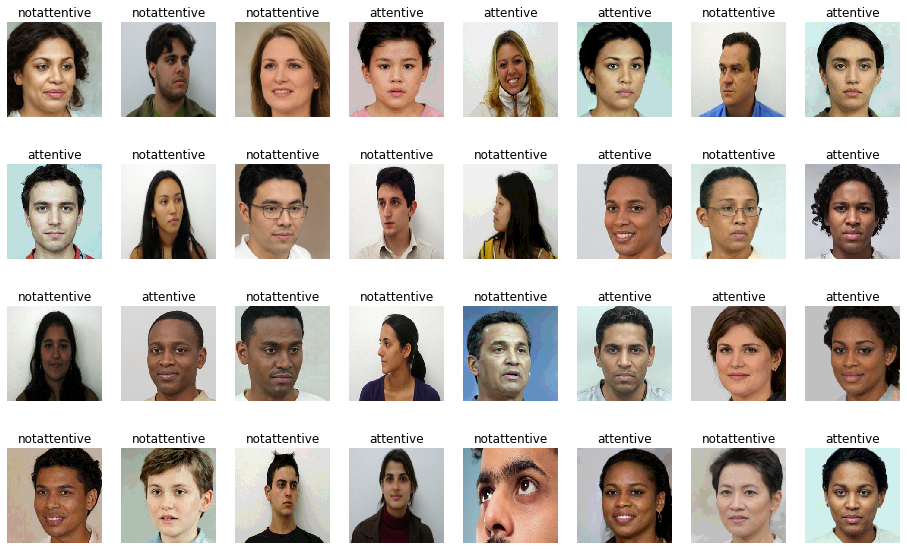

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))

plt.figure(figsize=(16, 10))
for i, (img, label) in enumerate(zip(inputs, labels)):
    plt.subplot(4, 8, i+1)
    if label == 1:
        plt.title('notattentive')
    else:
        plt.title('attentive') # automatically labeled zero (subdirectories are labeled in alphabetical order)
    plt.axis('off')
    plt.imshow(np.transpose(img.numpy(),(1,2,0)), interpolation="nearest")

**Note**: Torchvision could be utilized to preview the data augmentations, but one wouldn't be able to label each indvidual image. 

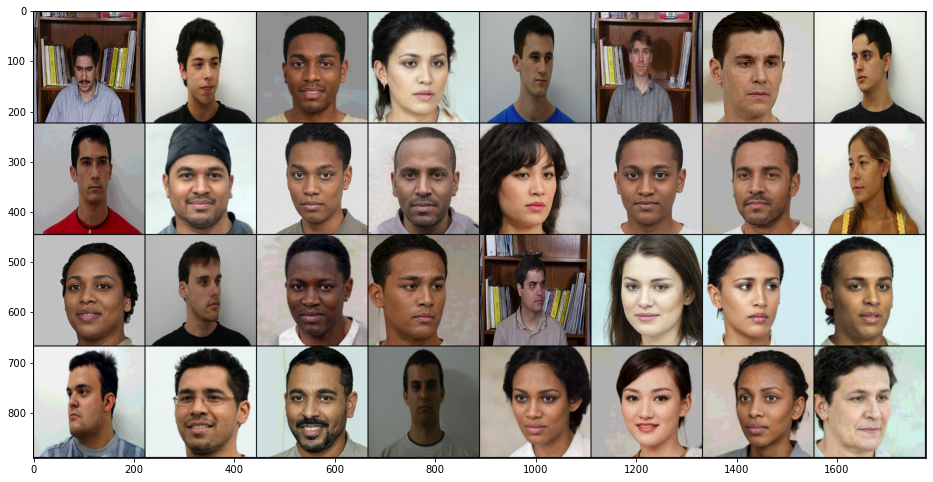

In [4]:
import torchvision 
inputs, labels = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(16, 10))
_ = plt.imshow(np.transpose(out.numpy(),(1,2,0)))

<p><a name="Transfer Learning"></a></p>

## Transfer Learning: Fine-Tuning

<p><a name="Load and Modify"></a></p>

### Load and Modify Model
Using a CNN pre-trained on a very large dataset, such as ImageNet, would yield much better results than training the CNN myself on a much more limited dataset. 

"In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest" (*https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor*).

ResNeXt-101-32x8d was chosen due to better performance compared to other [architectures](https://pytorch.org/vision/stable/models.html). Instead of increasing the depth or width, ResNeXt focuses on increasing cardinality to improve classification accuracy. Cardinality is the size of the set of transformations. 

The ResNeXt model was "pre-trained in weakly-supervised fashion on 940 million public images with 1.5K hashtags matching with 1000 ImageNet1K synsets, followed by fine-tuning on ImageNet1K dataset" (*https://pytorch.org/hub/facebookresearch_WSL-Images_resnext/#model-description*).

Paper: https://arxiv.org/abs/1611.05431

Models: https://pytorch.org/vision/stable/models.html#resnext

In [5]:
# from torch import device, cuda
import torch
from torchvision.models import resnext101_32x8d as Resnext101

# cpu vs gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Resnext101_32x8d model without the top fully-connected layers 
# since I will construct my own.
model = Resnext101(pretrained=True, progress = True)

In [6]:
for i, param in enumerate(model.named_parameters(), 1):
    print(f"{i}: {param[0]} {param[1].size()}")
    print(param[1].requires_grad,end='\n\n')

1: conv1.weight torch.Size([64, 3, 7, 7])
True

2: bn1.weight torch.Size([64])
True

3: bn1.bias torch.Size([64])
True

4: layer1.0.conv1.weight torch.Size([256, 64, 1, 1])
True

5: layer1.0.bn1.weight torch.Size([256])
True

6: layer1.0.bn1.bias torch.Size([256])
True

7: layer1.0.conv2.weight torch.Size([256, 8, 3, 3])
True

8: layer1.0.bn2.weight torch.Size([256])
True

9: layer1.0.bn2.bias torch.Size([256])
True

10: layer1.0.conv3.weight torch.Size([256, 256, 1, 1])
True

11: layer1.0.bn3.weight torch.Size([256])
True

12: layer1.0.bn3.bias torch.Size([256])
True

13: layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
True

14: layer1.0.downsample.1.weight torch.Size([256])
True

15: layer1.0.downsample.1.bias torch.Size([256])
True

16: layer1.1.conv1.weight torch.Size([256, 256, 1, 1])
True

17: layer1.1.bn1.weight torch.Size([256])
True

18: layer1.1.bn1.bias torch.Size([256])
True

19: layer1.1.conv2.weight torch.Size([256, 8, 3, 3])
True

20: layer1.1.bn2.weight torch.S

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [8]:
for i, param in enumerate(model.named_modules(), 1):
    print(f"{i}: {param[0], {param[1]}}\n\n")

1: ('', {ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kerne

In [9]:
from torchsummary import summary
summary(model, (3, 224, 224))

C:\Users\Tyrone\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
              ReLU-7          [-1, 256, 56, 56]               0
            Conv2d-8          [-1, 256, 56, 56]          18,432
       BatchNorm2d-9          [-1, 256, 56, 56]             512
             ReLU-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          65,536
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Ultiamtely, only layer 4 layers and the fully connected layers will be trained.

In [10]:
# Exclude subgraphs from gradient computation
for param in model.named_parameters():
    param[1].requires_grad = True if 'layer4' in param[0] else False 

In [11]:
for i, param in enumerate(model.named_parameters(), 1):
    print(f"{i}: {param[0]} {param[1].size()}")
    print(param[1].requires_grad,end='\n\n')

1: conv1.weight torch.Size([64, 3, 7, 7])
False

2: bn1.weight torch.Size([64])
False

3: bn1.bias torch.Size([64])
False

4: layer1.0.conv1.weight torch.Size([256, 64, 1, 1])
False

5: layer1.0.bn1.weight torch.Size([256])
False

6: layer1.0.bn1.bias torch.Size([256])
False

7: layer1.0.conv2.weight torch.Size([256, 8, 3, 3])
False

8: layer1.0.bn2.weight torch.Size([256])
False

9: layer1.0.bn2.bias torch.Size([256])
False

10: layer1.0.conv3.weight torch.Size([256, 256, 1, 1])
False

11: layer1.0.bn3.weight torch.Size([256])
False

12: layer1.0.bn3.bias torch.Size([256])
False

13: layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
False

14: layer1.0.downsample.1.weight torch.Size([256])
False

15: layer1.0.downsample.1.bias torch.Size([256])
False

16: layer1.1.conv1.weight torch.Size([256, 256, 1, 1])
False

17: layer1.1.bn1.weight torch.Size([256])
False

18: layer1.1.bn1.bias torch.Size([256])
False

19: layer1.1.conv2.weight torch.Size([256, 8, 3, 3])
False

20: layer1.1

The new head of the ResNeXt network.

In [12]:
# Create new fully connected layers.
import torch.nn as nn
model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 1),
            nn.Sigmoid())
model = model.to(device)

In [13]:
for i, param in enumerate(model.named_parameters(), 1):
    print(f"{i}: {param[0]}, \n{param[1].size()}")
    print(param[1].requires_grad,end='\n\n')

1: conv1.weight, 
torch.Size([64, 3, 7, 7])
False

2: bn1.weight, 
torch.Size([64])
False

3: bn1.bias, 
torch.Size([64])
False

4: layer1.0.conv1.weight, 
torch.Size([256, 64, 1, 1])
False

5: layer1.0.bn1.weight, 
torch.Size([256])
False

6: layer1.0.bn1.bias, 
torch.Size([256])
False

7: layer1.0.conv2.weight, 
torch.Size([256, 8, 3, 3])
False

8: layer1.0.bn2.weight, 
torch.Size([256])
False

9: layer1.0.bn2.bias, 
torch.Size([256])
False

10: layer1.0.conv3.weight, 
torch.Size([256, 256, 1, 1])
False

11: layer1.0.bn3.weight, 
torch.Size([256])
False

12: layer1.0.bn3.bias, 
torch.Size([256])
False

13: layer1.0.downsample.0.weight, 
torch.Size([256, 64, 1, 1])
False

14: layer1.0.downsample.1.weight, 
torch.Size([256])
False

15: layer1.0.downsample.1.bias, 
torch.Size([256])
False

16: layer1.1.conv1.weight, 
torch.Size([256, 256, 1, 1])
False

17: layer1.1.bn1.weight, 
torch.Size([256])
False

18: layer1.1.bn1.bias, 
torch.Size([256])
False

19: layer1.1.conv2.weight, 
torch.Si

In [14]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
              ReLU-7          [-1, 256, 56, 56]               0
            Conv2d-8          [-1, 256, 56, 56]          18,432
       BatchNorm2d-9          [-1, 256, 56, 56]             512
             ReLU-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          65,536
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Train Model
I use the generic training and visualization functions provided in PyTorch's documentation [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model) and [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#visualizing-the-model-predictions) respectively.

In [15]:
import time
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                # So labels can match shape and data format of model output
                labels = labels.view(-1,1).to(torch.float32).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.view(-1,1).to(torch.float32).to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
from torch import optim
criterion = nn.BCELoss()

# Remember, only selected parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Decay lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Train the model.

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------


Visualize the model.

In [ ]:
visualize_model(model)